In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Neural Style Transfer (Nöral Stil Transferi)
Neural Style Transfer ile bir temel resmin içeriği ve bir başka resmin stili birleştirilebilir. Örneğin bir modelden resminizi cubism akımı ile oluşturmasını isteyebilirsiniz.  


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import vgg19

import matplotlib.pyplot as plt 
import numpy as np


In [25]:
base_image_path = "/content/drive/MyDrive/Projects/Neural Style Transfer/city.jpg"
style_image_path= "/content/drive/MyDrive/Projects/Neural Style Transfer/van.jpg"

result_prefix = "city_generated"


total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

width,height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)
c  = 3

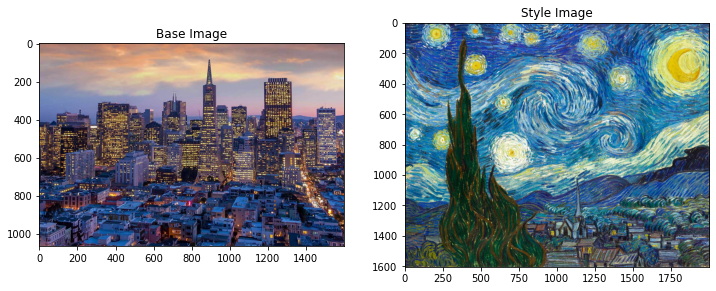

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Base Image")
plt.imshow(load_img(base_image_path))
plt.subplot(122)
plt.title("Style Image")
plt.imshow(load_img(style_image_path))
plt.show()

## Process ve Deprocess İşlemleri 
Process metodu, Image'ın okunması sayı dizisine çevrilmesi vgg modeline uygun hale getirilmesi işlemleri yapılır.   
Deprocess metodunda ise okunan tensorun resme çevrilmesi için kullanılır.   
Yapılan işlemler kodların üzerinde özetlenmiştir. 

In [27]:
def preprocess_image(image_path):
    # Keras load_img metodu ile image okunur. 
    img = load_img(image_path,target_size=(img_nrows,img_ncols))

    # modele göndermek için arraye çevrilir. 
    img_array = np.array(img)

    # model 1,H,W,C şeklinde data kabul ettiği için bir dimension eklenir. 
    img_array = np.expand_dims(img_array,0)
    
    # VGG19 modeline uygun şekilde preprocess işlemi yapılır. 
    processed_img = vgg19.preprocess_input(img_array)
    img_tensor = tf.convert_to_tensor(processed_img)
    return img_tensor


def deprocess_image(x):
    # X tensoru H,W,C şekline getirilir. Image formatına 
    x = x.reshape((img_nrows,img_ncols,3))

    # VGG19 modeline gönderirken 0 merkezli olacak şekilde düzenleme yapmıştık. 
    #(preprocess_input metodunu kullanarak) Bunu eski haline getir 
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR - RGB çevirmek için -> Array Slicing arr[::stride] -1 reverse order
    x = x[:,:,::-1] 

    # np.clip metodu gönderilen array içerisinde 0 dan küçük olan değerler için 0
    # 255 den büyük olan değerler için 255 olacak şekilde kırpma işlemi yapar. 
    x = np.clip(x,0,255).astype("uint8") 
    return x
    

## Gram Matriks Nedir? 
Bir conv layerda oluşturduğumuz filtrelerin her biri özellik çıkarmada kullanılır. Burada her bir filtre resim üzerinde farklı özelliklerin tespit edilmesini sağlar. Örneğin filtrelerden biri düz çizgileri diğeri köşeleri bir diğeri ise eğrilerin tespit edilesinde kullanılır.  
Bu özellik çıkartan filtreleri style oluşturmak için kullanmak istersek hangi özelliklerin birbiriyle bağlantılı olduğunu tespit etmemiz gerekir. Bunun için bu filtrelerin birbirleriyle olan korelasyonlarına bakabiliriz. Bu korelasyonu hesaplamak için bu filtreleri birleştirip bir matris şekline çevirelim daha sonra bu matrisin transposunu alarak nokta çarpım işlemi yapalım. Bu işlem sonucunda Gram Matriks elde ederiz. Yani kısaca gram matriks filtrelerin birbirleriyle olan korelasyonlarını tespit etmek için kullandığımız bir matirkstir. 

In [28]:
def gram_matrix(x):
    # H,W,C olan tensoru - > C,H,W şekline çevirelim. 
    x = tf.transpose(x, perm = (2, 0, 1)) 

    # C,H*W şekline rehsape etmek için
    features = tf.reshape(x, (tf.shape(x)[0], -1)) 

    # Korelasyonları(Gram matriks) bulmak  için X*XT işlemi yapalım. 
    gram = tf.matmul(features, tf.transpose(features))
    return gram



### Loss Fonksiyonları
Bu modelde 3 farklı loss hesaplayacağız: "style loss", "content loss" ve "total variation loss".   
* Content Loss üretilen resim ve base resim arasında l2 distance ile hesaplanır. Üretilen resmin base resme benzemesi için optimize edilir. 
* Style Loss, base resmin ve üretilen resmin katmanlarında hesaplanan gram matrislerin l2 distanceları ile hesaplanır. Üretilen resimdeki özelliklerin korelasyonunu base resimden çıkarılan özelliklerin korelasyonuna benzer olmasını optimize eder 

#### L2 Distance (Öklid Uzaklığı)
2 nokta arasındaki en kısa mesafeye göre hesaplanır.   
d = √[ (x2 – x1)2 + (y2 – y1)2]

In [29]:
def style_loss(style,generated):
    # style gram_matriksi hesaplanır. 
    S  = gram_matrix(style)
    # Generate edilen resmin style matriksi hesaplanır. 
    G = gram_matrix(generated)

    
    # makalede belirtilen formul ile hesaplanır. 
    return tf.reduce_sum(tf.square(S - G)) / (4.0 * (c ** 2) * ((img_nrows*img_ncols) ** 2))

def content_loss(base, generated):
    return tf.reduce_sum(tf.square(generated - base)) / (4.0 * (c*img_nrows*img_ncols))


def total_variation_loss(content_loss,style_loss,alpha=10,beta = 40):
    return content_loss + style_loss


## VGG19 Modeli 
Style'ın ve contentin üretilmesinde önceden eğitilmiş VGG19 modelini kullanacağız. Style için birden fazla katmanda style_loss hesaplayıp bunların toplamların ortalamasına göre style_loss değerini bulacağız. 
Content içinde özellik çıkarmada en başarılı olduğu son katmanlarından birini kullanacağız

In [30]:
# VGG19 modelini import ettik
vgg_model = vgg19.VGG19(include_top=False,weights="imagenet")

# Tüm layerları ve çıktıları bir dict içerisine atadık. 
layer_dict = dict([(layer.name,layer.output) for layer in vgg_model.layers])

# özellik çıkarmada kullanacağımız modeli oluşturduk. 
feature_extractor = tf.keras.models.Model(vgg_model.input,layer_dict)

# Style için kullanılacak layerlar
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# content için kullanılacak layer
content_layer_name = "block5_conv2"

In [31]:
def compute_loss(generated_image,base_image,style_image):
    # bir input tensoru oluşturduk.
    input_tensor = tf.concat([base_image,style_image,generated_image],axis=0)
    # özellik çıkarmada kullanacağımız modele gönderdik. 
    features = feature_extractor(input_tensor)

    # loss değerini tutmak için bir değişken oluşturduk. 
    c_loss = tf.zeros(shape=())
    s_loss = tf.zeros(shape=())
    t_loss = tf.zeros(shape=())


    # Content için kullanılacak layerdaki outpu değerlerini aldık. 
    layer_features = features[content_layer_name]
    # Bu arraydeki 0. değer base_imagein özellikleri 
    base_image_features = layer_features[0,:,:,:]
    # 2. değer üretilen imagein çıkarılan özellikleri 
    generated_features = layer_features[2,:,:,:]
    # content loss metodu kullanarak c_loss değeri hesaplanır
    c_loss = content_weight*content_loss(base_image_features,generated_features)

    
    # Style için kullanılacak layerlar ile s_loss değerleri hesaplanır .
    for layer_name in style_layer_names:
        # ilgili layerın çıktılarını aldık 
        layer_features = features[layer_name]
        # 1.si style inputunun özellikleri
        style_reference_features = layer_features[1,:,:,:]
        # 2.si generate edilen resmin özellikleri
        generated_features = layer_features[2,:,:,:]

        # ilgili layer için style_loss hesaplanır
        sl = style_loss(style_reference_features,generated_features)
        # s_loss değerine eklenir
        s_loss += (style_weight/len(style_layer_names))*sl

    # total loss metodu ile t_loss hesaplanır
    t_loss = total_variation_loss(c_loss,s_loss)
    return t_loss



# GradientTape
tf.GradientTape() tensorflow hesapları yapmamızı ve verilen değişkenlere göre gradient hesaplamımızı sağlar. 

Aşağıdaki örnekte y fonksiyonun x'e göre türevi alınır. 
4*(x^3) = 32 sonucu elde edilir. 


In [32]:
x = tf.Variable(2.0, trainable=True)
with tf.GradientTape() as tape:
    y = x**4
print(tape.gradient(y, x).numpy()) #32

32.0


In [33]:
# Bir fonksiyonu tensorflow graph üzerinde kullanmamıza olanak sağlar. 
# Normalde tensorflow 2 den sonra eager execution default seçenek oldu 
@tf.function
def compute_loss_and_grads(generated_image,base_image,style_image):
    with tf.GradientTape() as tape:
        # loss değeri hesaplanır 
        loss = compute_loss(generated_image,base_image,style_image)
    # generated_image de değişiklikler yapılarak loss değeri optimize edilir. 
    grads = tape.gradient(loss,generated_image)
    # loss ve gradient değerleri döndürülür.
    return loss,grads


In [35]:
#optimizer oluşturduk. lr değerini yüksek bir değer ile başlatıyoruz. 
# Her 100 stepte bir lr değerini düşürüyoruz. 
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

# base_image,style_image modele göndermek için preprocessing işleminden geçirdik. 
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000 
for i in range(1, iterations + 1):
    # loss ve gradient değerleri hesaplıyoruz.
    loss, grads = compute_loss_and_grads(
        generated_image, base_image, style_reference_image
    )
    # optimizer ile generated_image e gradient uygulanır ve generated image 
    # yeniden oluşturulur. 
    optimizer.apply_gradients([(grads, generated_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))

        # Üretilen image i save etmek için 
        img = deprocess_image(generated_image.numpy())
        fname = "/content/drive/MyDrive/Projects/Neural Style Transfer/generated/"+result_prefix + "_at_iteration_%d.png" % i
        tf.keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=1773.56
Iteration 200: loss=1201.04
Iteration 300: loss=938.38
Iteration 400: loss=778.06
Iteration 500: loss=667.72
Iteration 600: loss=586.36
Iteration 700: loss=523.92
Iteration 800: loss=474.45
Iteration 900: loss=434.40
Iteration 1000: loss=401.34
Iteration 1100: loss=373.73
Iteration 1200: loss=350.36
Iteration 1300: loss=330.37
Iteration 1400: loss=313.11
Iteration 1500: loss=298.11
Iteration 1600: loss=284.95
Iteration 1700: loss=273.34
Iteration 1800: loss=263.02
Iteration 1900: loss=253.82
Iteration 2000: loss=245.57
Iteration 2100: loss=238.14
Iteration 2200: loss=231.43
Iteration 2300: loss=225.34
Iteration 2400: loss=219.79
Iteration 2500: loss=214.72
Iteration 2600: loss=210.09
Iteration 2700: loss=205.83
Iteration 2800: loss=201.91
Iteration 2900: loss=198.29
Iteration 3000: loss=194.94
Iteration 3100: loss=191.84
Iteration 3200: loss=188.96
Iteration 3300: loss=186.29
Iteration 3400: loss=183.80
Iteration 3500: loss=181.48
Iteration 3600: loss=179.31